In [1]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
import optuna
from sklearn.preprocessing import LabelEncoder


In [2]:
#data
train=pd.read_csv("dataset/train_features.csv")
y=pd.read_csv("dataset/train_labels.csv")
test=pd.read_csv("dataset/test_features.csv")
ss=pd.read_csv("dataset/submission_format.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [8]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [9]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [10]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

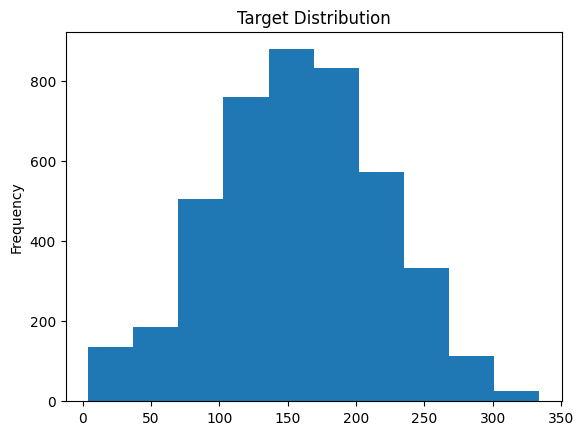

In [11]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [12]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    return data

In [13]:
def get_cat_cols(data):
    # Get the columns with object datatype
    cat_columns=[]
    dummies=[]
    for col in data.columns:
        if data[col].dtype=='object' and 'uid' not in col:
            cat_columns.append(col)
            dummies.append(col)
        elif data[col].dtype!='object' and 'uid' not in col and (data[col].max()==1.0):
            cat_columns.append(col)
            data[col].fillna(0, inplace=True)
        else:
            continue
    return cat_columns, dummies

In [14]:
def encode_cat_cols(train_data, cat_cols, dummy_cols):
    enc = OneHotEncoder()
    enc.fit(train_data[dummy_cols])
    encoded_train_data=enc.transform(train_data[dummy_cols]).toarray()
    feature_names = enc.get_feature_names_out(dummy_cols)
    train_data.drop(columns=dummy_cols, inplace=True)
    encoded_train_df = pd.DataFrame(encoded_train_data, columns=feature_names)
    train_data[feature_names]=encoded_train_df[feature_names]
    return train_data, feature_names

In [15]:
y=merged_df['composite_score']
data_processed=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data_processed = feature_engineering(data_processed)
cat_cols, dummy_cols = get_cat_cols(data_processed)
data_processed, dummy_feature_names=encode_cat_cols(data_processed, cat_cols, dummy_cols)
data_processed=data_processed.drop(columns=['composite_score'],axis=1)

for col in data_processed.columns: 
    if round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>50:
        data_processed.drop(columns=col, inplace=True)
    elif round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>5:
        print(col,round((data_processed[col].isna().sum() /len(data_processed)*100), 2), '% missing')
        data_processed[col].fillna(0, inplace=True)
    else: 
        data_processed[col].fillna(0, inplace=True)
        data_processed[col].fillna(0, inplace=True)

/tmp/ipykernel_943508/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_943508/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_943508/2658724754.py:13: FutureWarning: Downcasting behavior in `

n_mar_03 33.83 % missing
edu_gru_03 33.55 % missing
glob_hlth_03 36.99 % missing
n_adl_03 33.5 % missing
n_iadl_03 36.99 % missing
n_depr_03 37.1 % missing
n_illnesses_03 33.31 % missing
decis_personal_03 37.17 % missing
glob_hlth_12 5.8 % missing
n_iadl_12 5.84 % missing
n_depr_12 6.52 % missing
bmi_12 12.48 % missing
memory_12 6.72 % missing
rearnings_03 33.37 % missing
searnings_03 49.98 % missing
hincome_03 34.01 % missing
hinc_business_03 32.98 % missing
hinc_rent_03 32.98 % missing
hinc_assets_03 32.98 % missing
hinc_cap_03 32.98 % missing
rinc_pension_03 33.37 % missing
sinc_pension_03 49.98 % missing
searnings_12 35.19 % missing
sinc_pension_12 35.19 % missing
hincome_change 37.28 % missing
niadl_change 41.13 % missing
adl_change 36.4 % missing
depr_change 41.65 % missing
glob_hlth_change 41.1 % missing
edu_gru_change 36.09 % missing
illnesses_change 36.29 % missing


/tmp/ipykernel_943508/3102208485.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_processed[col].fillna(0, inplace=True)
/tmp/ipykernel_943508/3102208485.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [16]:
y=merged_df['composite_score']
data_tabnet=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data_tabnet = feature_engineering(data_tabnet)
data_tabnet=data_tabnet.drop(columns=['uid', 'composite_score'],axis=1)

categorical_columns = []
categorical_dims =  {}
for col in data_tabnet.select_dtypes(include=['object', 'category']).columns:
    print(col, data_tabnet[col].nunique())
    l_enc = LabelEncoder()
    data_tabnet[col] = data_tabnet[col].fillna("Missing")
    data_tabnet[col] = l_enc.fit_transform(data_tabnet[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in data_tabnet.columns[data_tabnet.dtypes == 'float64']:
    data_tabnet.fillna(data_tabnet.loc[:, col].mean(), inplace=True)

/tmp/ipykernel_943508/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_943508/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_943508/2658724754.py:13: FutureWarning: Downcasting behavior in `

age_03 5
urban_03 2
married_03 4
n_living_child_03 5
decis_famil_03 3
employment_03 4
age_12 5
urban_12 2
married_12 4
n_living_child_12 5
decis_famil_12 3
decis_personal_12 3
employment_12 4
satis_ideal_12 3
satis_excel_12 3
satis_fine_12 3
cosas_imp_12 3
wouldnt_change_12 3
ragender 2
rameduc_m 4
rafeduc_m 4
sgender_03 2
rjlocc_m_03 18
rjobend_reason_03 5
rrelgimp_03 3
sgender_12 2
rjlocc_m_12 18
rjobend_reason_12 5
rrelgimp_12 3
rrfcntx_m_12 9
rsocact_m_12 9
rrelgwk_12 2
a22_12 7
a33b_12 3
a34_12 2
j11_12 3


In [17]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data = feature_engineering(data)
data=data.drop(columns=['composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

/tmp/ipykernel_943508/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_943508/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_943508/2658724754.py:13: FutureWarning: Downcasting behavior in `

In [18]:
#separate train and test
merged_df_processed=data_processed[:len(merged_df)]
merged_test_processed=data_processed[len(merged_df):]

In [19]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [20]:
#separate train and test
merged_df_tabnet=data_tabnet[:len(merged_df)]
merged_test_tabnet=data_tabnet[len(merged_df):]

In [21]:
features = [ col for col in merged_df_tabnet.columns] + ["glob_hlth_03", "glob_hlth_12", "bmi_03", "bmi_12", "memory_12", "edu_gru_03",  "edu_gru_12"]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [22]:
merged_df.shape

(4343, 196)

In [23]:
merged_df_processed.shape

(4343, 349)

In [ ]:
def objective_tabnet(trial, train_X, train_y, val_X, val_y):
    # Identify categorical features
    # Here we assume categorical features are of type 'category' or 'object'.
    # If your categorical features are already integer-encoded, adjust accordingly.
    cat_cols = [col for col in train_X.columns if str(train_X[col].dtype) in ['object', 'category']]
    cat_idxs = [train_X.columns.get_loc(c) for c in cat_cols]
    cat_dims = [train_X[c].nunique() for c in cat_cols]

    # Convert data to NumPy arrays
    X_train = train_X.values
    y_train = train_y.values.reshape(-1, 1)
    X_val = val_X.values
    y_val = val_y.values.reshape(-1, 1)

    # Suggest hyperparameters with Optuna
    params = {
        'n_d': trial.suggest_int('n_d', 8, 64),
        'n_a': trial.suggest_int('n_a', 8, 64),
        'n_steps': trial.suggest_int('n_steps', 3, 10),
        'gamma': trial.suggest_uniform('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_loguniform('lambda_sparse', 1e-6, 1e-1),
        'cat_emb_dim': trial.suggest_int('cat_emb_dim', 1, 10),
        'lr': trial.suggest_loguniform('lr', 1e-3, 1e-1),
        'momentum': trial.suggest_uniform('momentum', 0.01, 0.4)
    }

    # Initialize TabNetRegressor
    model = TabNetRegressor(
        n_d=params['n_d'],
        n_a=params['n_a'],
        n_steps=params['n_steps'],
        gamma=params['gamma'],
        lambda_sparse=params['lambda_sparse'],
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=params['cat_emb_dim'],
        optimizer_params={'lr': params['lr']},
        momentum=params['momentum'],
        seed=42
    )

    # Fit the model with early stopping
    model.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_val, y_val)],
        max_epochs=1000,
        patience=50,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # Predict and evaluate
    preds = model.predict(X_val).flatten()
    rmse = root_mean_squared_error(y_val.flatten(), preds)
    return rmse


# Define an objective function for Optuna for each model
def objective_lightgbm(trial, train_X, train_y, val_X, val_y):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        "random_state": 42,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 50.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 50.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000)
    }

    train_data = lgb.Dataset(train_X, label=train_y)
    val_data = lgb.Dataset(val_X, label=val_y, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=params['n_estimators'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=False),
        ]
    )

    preds = model.predict(val_X, num_iteration=model.best_iteration)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_catboost(trial, train_X, train_y, val_X, val_y):
    params = {
        'depth': trial.suggest_int('depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'iterations': trial.suggest_int('iterations', 50, 5000)
    }

    model = CatBoostRegressor(
        **params,
        loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=0, early_stopping_rounds = 500,
        random_state=42
    )
    model.fit(train_X, train_y, eval_set=(val_X, val_y))

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_xgboost(trial, train_X, train_y, val_X, val_y):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 50.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 50.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000)
    }

    model = XGBRegressor(**params,
                         enable_categorical=True,
                         eval_metric=root_mean_squared_error,
                         early_stopping_rounds=500,
                         random_state=42)
    model.fit(
        train_X, train_y,
        eval_set=[(val_X, val_y)],
        verbose=False,
    )

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_randomforest(trial, train_X, train_y, val_X, val_y):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 50, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000)
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(train_X, train_y)

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

# Run Optuna for each model and store the best parameters
best_params = {}
for model_name, objective in zip(
    ['TabNet', 'lightgbm', 'RandomForest', 'XGBoost', 'CatBoost'],
    [objective_tabnet, objective_lightgbm, objective_randomforest, objective_xgboost, objective_catboost]
):
    study = optuna.create_study(direction='minimize')
    if model_name == 'RandomForest':
        unique_uids = merged_df_processed['uid'].unique()
        train_ids, val_ids = train_test_split(unique_uids, test_size=0.2, random_state=42)
        keep_train = merged_df_processed['uid'].isin(train_ids)
        keep_val = merged_df_processed['uid'].isin(val_ids)
        train_X, val_X = merged_df_processed[keep_train],merged_df_processed[keep_val]
        train_X.drop(columns=['uid'], inplace=True)
        val_X.drop(columns=['uid'], inplace=True)
        train_y, val_y= y[keep_train], y[keep_val]
        # train_X, val_X, train_y, val_y = train_test_split(merged_df_processed, y, test_size=0.2, random_state=42)
    else:
        unique_uids = merged_df['uid'].unique()
        train_ids, val_ids = train_test_split(unique_uids, test_size=0.2, random_state=42)
        keep_train = merged_df['uid'].isin(train_ids)
        keep_val = merged_df['uid'].isin(val_ids)
        train_X, val_X = merged_df[keep_train],merged_df[keep_val]
        train_X.drop(columns=['uid'], inplace=True)
        val_X.drop(columns=['uid'], inplace=True)
        train_y, val_y= y[keep_train], y[keep_val]
        # train_X, val_X, train_y, val_y = train_test_split(merged_df, y, test_size=0.2, random_state=42)
    study.optimize(lambda trial: objective(trial, train_X, train_y, val_X, val_y), n_trials=100, n_jobs=-1, show_progress_bar=True)
    best_params[model_name] = study.best_params
    print(f"Best params for {model_name}: {study.best_params}")
    print(f"Best RMSE for {model_name}: {study.best_value}")

In [24]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []
unique_uids = merged_df['uid'].unique()  # Extract unique uids

for train_index, val_index in tqdm(kf.split(merged_df)):
    # Split the data
    train_X, val_X = merged_df.iloc[train_index], merged_df.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]
    train_X.drop(columns=['uid'], inplace=True)
    val_X.drop(columns=['uid'], inplace=True)
    cats = train_X.select_dtypes(include=['object', 'category']).columns.to_list()
    
    train_X_processed, val_X_processed = merged_df_processed.iloc[train_index], merged_df_processed.iloc[val_index]
    train_X_processed.drop(columns=['uid'], inplace=True)
    val_X_processed.drop(columns=['uid'], inplace=True)
    
    train_X_tabnet, val_X_tabnet = merged_df_tabnet.iloc[train_index], merged_df_tabnet.iloc[val_index]

    # TabNet Addition: Train TabNet
    model5 =  TabNetRegressor(
                seed=42,
            )
    # TabNet expects numpy arrays
    model5.fit(
        train_X_tabnet.values, train_y.values.reshape(-1, 1),
        eval_set=[(val_X_tabnet.values, val_y.values.reshape(-1, 1))],
        max_epochs=100,
        patience=20,
        batch_size=128,
        virtual_batch_size=32,
        eval_metric=['rmse']
    )
    pred5 = model5.predict(val_X_tabnet.values).ravel()
    print("TabNet rmse: ", root_mean_squared_error(val_y, pred5))
    

    # Train LightGBM
    train_data = lgb.Dataset(train_X, label=train_y, categorical_feature='auto')
    val_data = lgb.Dataset(val_X, label=val_y, categorical_feature='auto')

    # Define parameters
    params = {
        'objective': 'regression',  # default for regression
        'metric': 'rmse',
        'learning_rate': 0.01,
        'n_estimators': 10000,
        'random_seed': 42
    }

    # Train the model with early stopping
    model1 = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
        ]
    )
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration)

    # Train CatBoost
    model2 = CatBoostRegressor(
        iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
        cat_features=cats,
        verbose=100, early_stopping_rounds=500
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)
    
    # Train XGBoost
    model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)
    
    # Train Random Forest
    model4 = RandomForestRegressor(n_estimators=1000, random_state=42)
    model4.fit(train_X_processed, train_y)
    pred4 = model4.predict(val_X_processed)
    print("RandomForest rmse: ", root_mean_squared_error(val_y, pred4))

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3, w4, w5 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3 + w4 * pred4 + w5 * pred5
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights (now 1/5 each)
    initial_weights = [1/5, 1/5, 1/5, 1/5, 1/5]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: sum(w) - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1)] * 5

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3 +
        optimized_weights[3] * pred4 + 
        optimized_weights[4] * pred5
    )

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]/tmp/ipykernel_943508/2235415930.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2

epoch 0  | loss: 27034.62688| val_0_rmse: 151.47995|  0:00:01s
epoch 1  | loss: 21105.89099| val_0_rmse: 107.7636|  0:00:01s
epoch 2  | loss: 10281.63585| val_0_rmse: 65.1513 |  0:00:02s
epoch 3  | loss: 3577.35938| val_0_rmse: 57.26089|  0:00:02s
epoch 4  | loss: 2874.17829| val_0_rmse: 56.52067|  0:00:03s
epoch 5  | loss: 2613.2498| val_0_rmse: 57.80175|  0:00:04s
epoch 6  | loss: 2321.20288| val_0_rmse: 55.02645|  0:00:04s
epoch 7  | loss: 2250.99685| val_0_rmse: 58.46734|  0:00:05s
epoch 8  | loss: 2150.04614| val_0_rmse: 58.02267|  0:00:06s
epoch 9  | loss: 2068.24385| val_0_rmse: 55.21499|  0:00:06s
epoch 10 | loss: 2017.62246| val_0_rmse: 59.1336 |  0:00:07s
epoch 11 | loss: 1931.20032| val_0_rmse: 49.20462|  0:00:07s
epoch 12 | loss: 1923.8201| val_0_rmse: 51.25371|  0:00:08s
epoch 13 | loss: 1840.9865| val_0_rmse: 53.93081|  0:00:09s
epoch 14 | loss: 1907.15897| val_0_rmse: 46.90437|  0:00:09s
epoch 15 | loss: 1837.4624| val_0_rmse: 46.59108|  0:00:10s
epoch 16 | loss: 1789.35

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet rmse:  39.85521157275987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 195
[LightGBM] [Info] Start training from score 157.136730
Training until validation scores don't improve for 500 rounds


/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1327]	valid_0's rmse: 36.6658
0:	learn: 61.1063627	test: 58.7987195	best: 58.7987195 (0)	total: 64.4ms	remaining: 10m 43s
100:	learn: 45.4018050	test: 45.7213248	best: 45.7213248 (100)	total: 2.17s	remaining: 3m 32s
200:	learn: 39.1611918	test: 41.5629577	best: 41.5629577 (200)	total: 4.52s	remaining: 3m 40s
300:	learn: 35.6709280	test: 39.8673791	best: 39.8673791 (300)	total: 7.06s	remaining: 3m 47s
400:	learn: 33.4245825	test: 39.1252152	best: 39.1252152 (400)	total: 9.34s	remaining: 3m 43s
500:	learn: 31.6828754	test: 38.6249708	best: 38.6249708 (500)	total: 11.6s	remaining: 3m 40s
600:	learn: 30.2828383	test: 38.3301718	best: 38.3301718 (600)	total: 13.9s	remaining: 3m 37s
700:	learn: 29.0905266	test: 38.0912449	best: 38.0912449 (700)	total: 16.3s	remaining: 3m 36s
800:	learn: 28.1201608	test: 37.9189765	best: 37.9186493 (797)	total: 18.7s	remaining: 3m 35s
900:	learn: 27.2881546	test: 37.7823027	best: 37.7823027 (900)	total: 21.3s	remaining: 3m 

1it [06:35, 395.38s/it]

RandomForest rmse:  37.40206908073587


/tmp/ipykernel_943508/2235415930.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:19: S

epoch 0  | loss: 26937.40133| val_0_rmse: 153.03143|  0:00:00s
epoch 1  | loss: 20698.94513| val_0_rmse: 113.49322|  0:00:01s
epoch 2  | loss: 9412.53349| val_0_rmse: 65.82485|  0:00:01s
epoch 3  | loss: 3200.23072| val_0_rmse: 48.60226|  0:00:02s
epoch 4  | loss: 2582.9005| val_0_rmse: 55.08369|  0:00:03s
epoch 5  | loss: 2458.6756| val_0_rmse: 47.92819|  0:00:03s
epoch 6  | loss: 2341.74626| val_0_rmse: 48.28047|  0:00:04s
epoch 7  | loss: 2250.45025| val_0_rmse: 54.6949 |  0:00:04s
epoch 8  | loss: 2224.95042| val_0_rmse: 46.68572|  0:00:05s
epoch 9  | loss: 2172.1892| val_0_rmse: 47.25666|  0:00:06s
epoch 10 | loss: 2128.96574| val_0_rmse: 44.67372|  0:00:06s
epoch 11 | loss: 2117.22338| val_0_rmse: 45.68985|  0:00:07s
epoch 12 | loss: 2001.11372| val_0_rmse: 44.12134|  0:00:07s
epoch 13 | loss: 1974.75716| val_0_rmse: 43.24651|  0:00:08s
epoch 14 | loss: 1891.68799| val_0_rmse: 42.55016|  0:00:09s
epoch 15 | loss: 1903.72789| val_0_rmse: 43.38971|  0:00:09s
epoch 16 | loss: 1849.0

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet rmse:  40.148766974512824
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 195
[LightGBM] [Info] Start training from score 157.271445
Training until validation scores don't improve for 500 rounds


/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[2284]	valid_0's rmse: 36.4195
0:	learn: 59.9907902	test: 63.2094615	best: 63.2094615 (0)	total: 20.1ms	remaining: 3m 21s
100:	learn: 45.1310654	test: 47.6070807	best: 47.6070807 (100)	total: 2.11s	remaining: 3m 26s
200:	learn: 38.9875127	test: 42.4352906	best: 42.4352906 (200)	total: 4.37s	remaining: 3m 32s
300:	learn: 35.5235392	test: 40.2150772	best: 40.2150772 (300)	total: 6.63s	remaining: 3m 33s
400:	learn: 33.1813938	test: 39.1194870	best: 39.1194870 (400)	total: 9.09s	remaining: 3m 37s
500:	learn: 31.5564557	test: 38.5151816	best: 38.5151816 (500)	total: 11.4s	remaining: 3m 36s
600:	learn: 30.1657989	test: 38.1346801	best: 38.1346801 (600)	total: 13.8s	remaining: 3m 35s
700:	learn: 28.9884767	test: 37.8868718	best: 37.8868718 (700)	total: 16.1s	remaining: 3m 33s
800:	learn: 27.9626990	test: 37.6847878	best: 37.6847878 (800)	total: 18.6s	remaining: 3m 33s
900:	learn: 27.0020625	test: 37.5285275	best: 37.5285275 (900)	total: 21.1s	remaining: 3m 3

2it [11:10, 324.62s/it]

RandomForest rmse:  36.69250054018981


/tmp/ipykernel_943508/2235415930.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:19: S

epoch 0  | loss: 26796.30346| val_0_rmse: 158.844 |  0:00:00s
epoch 1  | loss: 20926.82863| val_0_rmse: 113.26237|  0:00:01s
epoch 2  | loss: 9554.13862| val_0_rmse: 65.23194|  0:00:01s
epoch 3  | loss: 2736.38697| val_0_rmse: 50.08222|  0:00:02s
epoch 4  | loss: 2331.7134| val_0_rmse: 47.66988|  0:00:03s
epoch 5  | loss: 2287.67306| val_0_rmse: 49.12825|  0:00:03s
epoch 6  | loss: 2224.84608| val_0_rmse: 49.83205|  0:00:04s
epoch 7  | loss: 2256.10851| val_0_rmse: 47.26639|  0:00:04s
epoch 8  | loss: 2208.86642| val_0_rmse: 47.08586|  0:00:05s
epoch 9  | loss: 2187.28738| val_0_rmse: 47.48021|  0:00:06s
epoch 10 | loss: 2221.95541| val_0_rmse: 47.16441|  0:00:06s
epoch 11 | loss: 2172.94931| val_0_rmse: 48.6149 |  0:00:07s
epoch 12 | loss: 2158.90586| val_0_rmse: 47.73388|  0:00:08s
epoch 13 | loss: 2195.72532| val_0_rmse: 51.03846|  0:00:08s
epoch 14 | loss: 2149.44209| val_0_rmse: 47.5841 |  0:00:09s
epoch 15 | loss: 2073.88732| val_0_rmse: 48.47351|  0:00:09s
epoch 16 | loss: 2059.

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet rmse:  40.91035912554759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1932
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 195
[LightGBM] [Info] Start training from score 156.375360
Training until validation scores don't improve for 500 rounds


/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[2065]	valid_0's rmse: 38.9767
0:	learn: 60.9116757	test: 59.6139346	best: 59.6139346 (0)	total: 17.5ms	remaining: 2m 54s
100:	learn: 45.2551866	test: 46.8663004	best: 46.8663004 (100)	total: 2.05s	remaining: 3m 20s
200:	learn: 39.0381907	test: 42.8832168	best: 42.8832168 (200)	total: 4.29s	remaining: 3m 29s
300:	learn: 35.5866766	test: 41.2763239	best: 41.2763239 (300)	total: 6.66s	remaining: 3m 34s
400:	learn: 33.2124296	test: 40.4566551	best: 40.4566551 (400)	total: 8.97s	remaining: 3m 34s
500:	learn: 31.4563911	test: 39.9630781	best: 39.9630781 (500)	total: 11.4s	remaining: 3m 35s
600:	learn: 30.0788486	test: 39.6401711	best: 39.6401711 (600)	total: 13.8s	remaining: 3m 35s
700:	learn: 28.8538656	test: 39.3996568	best: 39.3996568 (700)	total: 16.3s	remaining: 3m 35s
800:	learn: 27.7510599	test: 39.2196675	best: 39.2196675 (800)	total: 18.7s	remaining: 3m 34s
900:	learn: 26.7858254	test: 39.0791816	best: 39.0791816 (900)	total: 21.2s	remaining: 3m 3

3it [17:23, 346.52s/it]

RandomForest rmse:  39.21013864482763


/tmp/ipykernel_943508/2235415930.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:19: S

epoch 0  | loss: 26932.67245| val_0_rmse: 153.17664|  0:00:00s
epoch 1  | loss: 21048.53653| val_0_rmse: 107.83884|  0:00:01s
epoch 2  | loss: 10658.34189| val_0_rmse: 70.4447 |  0:00:01s
epoch 3  | loss: 3152.79966| val_0_rmse: 51.53293|  0:00:02s
epoch 4  | loss: 2408.53721| val_0_rmse: 49.50357|  0:00:03s
epoch 5  | loss: 2330.11542| val_0_rmse: 50.74617|  0:00:03s
epoch 6  | loss: 2265.66523| val_0_rmse: 48.30674|  0:00:04s
epoch 7  | loss: 2258.42169| val_0_rmse: 46.20687|  0:00:04s
epoch 8  | loss: 2257.98776| val_0_rmse: 48.60777|  0:00:05s
epoch 9  | loss: 2263.98357| val_0_rmse: 48.39067|  0:00:06s
epoch 10 | loss: 2181.4696| val_0_rmse: 46.73265|  0:00:06s
epoch 11 | loss: 2185.38603| val_0_rmse: 46.19904|  0:00:07s
epoch 12 | loss: 2182.78446| val_0_rmse: 46.32594|  0:00:08s
epoch 13 | loss: 2125.01167| val_0_rmse: 45.47919|  0:00:08s
epoch 14 | loss: 2083.50343| val_0_rmse: 45.28146|  0:00:09s
epoch 15 | loss: 2071.993| val_0_rmse: 45.34933|  0:00:09s
epoch 16 | loss: 2048.

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet rmse:  39.13452946108786
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 195
[LightGBM] [Info] Start training from score 157.237122
Training until validation scores don't improve for 500 rounds


/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[3802]	valid_0's rmse: 36.3882
0:	learn: 60.6043997	test: 60.8094701	best: 60.8094701 (0)	total: 20.7ms	remaining: 3m 27s
100:	learn: 45.2304994	test: 46.8621180	best: 46.8621180 (100)	total: 2.19s	remaining: 3m 34s
200:	learn: 39.0570311	test: 42.5034486	best: 42.5034486 (200)	total: 4.48s	remaining: 3m 38s
300:	learn: 35.6824354	test: 40.7313926	best: 40.7313926 (300)	total: 6.82s	remaining: 3m 39s
400:	learn: 33.4889507	test: 39.9037931	best: 39.9037931 (400)	total: 9.15s	remaining: 3m 38s
500:	learn: 31.7965815	test: 39.3931466	best: 39.3931466 (500)	total: 11.5s	remaining: 3m 38s
600:	learn: 30.3798993	test: 39.0556815	best: 39.0556815 (600)	total: 13.9s	remaining: 3m 37s
700:	learn: 29.1462259	test: 38.7950023	best: 38.7950023 (700)	total: 16.3s	remaining: 3m 36s
800:	learn: 28.1344076	test: 38.5992684	best: 38.5992684 (800)	total: 18.8s	remaining: 3m 36s
900:	learn: 27.1589611	test: 38.4292030	best: 38.4290308 (897)	total: 21.3s	remaining: 3m 3

4it [25:18, 397.52s/it]

RandomForest rmse:  37.18997965804012


/tmp/ipykernel_943508/2235415930.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2235415930.py:19: S

epoch 0  | loss: 26922.07321| val_0_rmse: 145.06559|  0:00:00s
epoch 1  | loss: 20759.9188| val_0_rmse: 124.02239|  0:00:01s
epoch 2  | loss: 9701.48501| val_0_rmse: 72.50898|  0:00:01s
epoch 3  | loss: 3161.59002| val_0_rmse: 63.76739|  0:00:02s
epoch 4  | loss: 2679.16259| val_0_rmse: 59.13793|  0:00:03s
epoch 5  | loss: 2364.08683| val_0_rmse: 56.28936|  0:00:04s
epoch 6  | loss: 2205.73842| val_0_rmse: 50.99976|  0:00:04s
epoch 7  | loss: 2063.44127| val_0_rmse: 52.59684|  0:00:05s
epoch 8  | loss: 1953.22035| val_0_rmse: 57.45335|  0:00:06s
epoch 9  | loss: 1955.15904| val_0_rmse: 56.17068|  0:00:06s
epoch 10 | loss: 1881.86737| val_0_rmse: 54.37781|  0:00:07s
epoch 11 | loss: 1813.6242| val_0_rmse: 54.42677|  0:00:08s
epoch 12 | loss: 1769.41052| val_0_rmse: 50.66613|  0:00:08s
epoch 13 | loss: 1723.11006| val_0_rmse: 46.5792 |  0:00:09s
epoch 14 | loss: 1700.39319| val_0_rmse: 48.07808|  0:00:09s
epoch 15 | loss: 1660.17491| val_0_rmse: 47.26999|  0:00:10s
epoch 16 | loss: 1654.

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet rmse:  43.49638381976668


/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.224264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 195
[LightGBM] [Info] Start training from score 157.063309
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1809]	valid_0's rmse: 40.3567
0:	learn: 60.6020805	test: 60.8146220	best: 60.8146220 (0)	total: 54.2ms	remaining: 9m 2s
100:	learn: 44.7876389	test: 47.7821271	best: 47.7821271 (100)	total: 2.25s	remaining: 3m 40s
200:	learn: 38.4413773	test: 43.9840904	best: 43.9840904 (200)	total: 4.51s	remaining: 3m 39s
300:	learn: 34.9888618	test: 42.4981671	best: 42.4981671 (300)	total: 6.95s	remaining: 3m 43s
400:	learn: 32.6991160	test: 41.7931370	best: 41.7931370 (400)	total: 9.27s	remaining: 3m 41

5it [30:41, 368.34s/it]

RandomForest rmse:  40.68354456865029
Average MSE across folds: 36.93934050449245
Optimized weights per fold: [array([0.19339243, 0.35164645, 0.12194966, 0.16176169, 0.17124977]), array([0.34754495, 0.22780456, 0.06915199, 0.24460673, 0.11089177]), array([0.        , 0.5267678 , 0.20173902, 0.07152367, 0.19996951]), array([0.38598819, 0.08396596, 0.14886422, 0.22545719, 0.15572469]), array([1.56450200e-01, 6.60906685e-01, 4.69712770e-13, 1.45516450e-01,
       3.71266647e-02])]


In [257]:
print(f"Average MSE across folds: {np.mean(fold_results)}")

Average MSE across folds: 40.04082018188872


In [25]:
print(f"Average MSE across folds: {np.mean(fold_results)}")

Average MSE across folds: 36.93934050449245


In [26]:
merged_df.drop(columns=['uid'], inplace=True)
merged_test.drop(columns=['uid'], inplace=True)
merged_df_processed.drop(columns=['uid'], inplace=True)
merged_test_processed.drop(columns=['uid'], inplace=True)

/tmp/ipykernel_943508/2509482186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2509482186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_test.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2509482186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_943508/2509482186.p

In [27]:
optimized_weights_list

[array([0.19339243, 0.35164645, 0.12194966, 0.16176169, 0.17124977]),
 array([0.34754495, 0.22780456, 0.06915199, 0.24460673, 0.11089177]),
 array([0.        , 0.5267678 , 0.20173902, 0.07152367, 0.19996951]),
 array([0.38598819, 0.08396596, 0.14886422, 0.22545719, 0.15572469]),
 array([1.56450200e-01, 6.60906685e-01, 4.69712770e-13, 1.45516450e-01,
        3.71266647e-02])]

In [30]:
np.mean(optimized_weights_list, axis=0)

array([0.21667516, 0.37021829, 0.10834098, 0.16977315, 0.13499248])

In [28]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)


# TabNet Addition: Train TabNet
final_model5 =  TabNetRegressor(
            seed=42
        )

final_model5.fit(
    merged_df_tabnet.values, y.values.reshape(-1, 1),
    max_epochs=40,
    batch_size=128,
    virtual_batch_size=32,
    eval_metric=['rmse']
)

# Train models on the entire training dataset
train_data = lgb.Dataset(merged_df, label=y, categorical_feature='auto')

params = {
    'objective': 'regression',  # default for regression
    'metric': 'rmse',
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'random_seed': 42
}
final_model1 = lgb.train(
    params,
    train_data
)

final_model2 = CatBoostRegressor(
    iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error)
final_model3.fit(merged_df, y)

# Train Random Forest
final_model4 = RandomForestRegressor(n_estimators=1000, random_state=42)
final_model4.fit(merged_df_processed, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)
test_pred3 = final_model3.predict(merged_test)
test_pred4 = final_model4.predict(merged_test_processed)
test_pred5 = final_model5.predict(merged_test_tabnet.values).ravel()

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + 
    average_weights[1] * test_pred2 + 
    average_weights[2] * test_pred3 +
    average_weights[3] * test_pred4 +
    average_weights[4] * test_pred5
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('dataset/LGBM_and_CatBoost_and_XGBoost_RandomForest_TabNet_engineering_3.csv', index=False)

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 26377.85819|  0:00:00s
epoch 1  | loss: 17215.63258|  0:00:01s
epoch 2  | loss: 4386.34172|  0:00:02s
epoch 3  | loss: 2397.21258|  0:00:02s
epoch 4  | loss: 2252.42459|  0:00:03s
epoch 5  | loss: 2216.85756|  0:00:04s
epoch 6  | loss: 2155.13417|  0:00:04s
epoch 7  | loss: 2110.09249|  0:00:05s
epoch 8  | loss: 2068.50956|  0:00:06s
epoch 9  | loss: 1990.38272|  0:00:06s
epoch 10 | loss: 1883.04275|  0:00:07s
epoch 11 | loss: 1827.89516|  0:00:08s
epoch 12 | loss: 1797.80285|  0:00:08s
epoch 13 | loss: 1834.34994|  0:00:09s
epoch 14 | loss: 1837.47727|  0:00:10s
epoch 15 | loss: 1770.52994|  0:00:10s
epoch 16 | loss: 1772.50751|  0:00:11s
epoch 17 | loss: 1769.15787|  0:00:12s
epoch 18 | loss: 1736.00471|  0:00:12s
epoch 19 | loss: 1727.82227|  0:00:13s
epoch 20 | loss: 1698.94354|  0:00:14s
epoch 21 | loss: 1710.66203|  0:00:14s
epoch 22 | loss: 1709.96817|  0:00:15s
epoch 23 | loss: 1728.67289|  0:00:16s
epoch 24 | loss: 1668.71088|  0:00:16s
epoch 25 | loss: 1620.3

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2030
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 195
[LightGBM] [Info] Start training from score 157.016809
0:	learn: 60.6706359	total: 5.68ms	remaining: 56.8s
100:	learn: 45.1469297	total: 2.13s	remaining: 3m 28s
200:	learn: 39.1364111	total: 4.58s	remaining: 3m 43s
300:	learn: 35.8111622	total: 7.1s	remaining: 3m 48s
400:	learn: 33.7047091	total: 9.55s	remaining: 3m 48s
500:	learn: 32.1122361	total: 12.1s	remaining: 3m 48s
600:	learn: 30.7861504	total: 14.5s	remaining: 3m 46s
700:	learn: 29.6481136	total: 17s	remaining: 3m 45s
800:	learn: 28.6747853	total: 19.5s	remaining: 3m 44s
900:	learn: 27.7920805	total: 22s	remaining: 3m 42s
1000:	learn: 26.9744507	total: 24.8s	remaining: 3m 42s
1100